In [1]:
import pickle
import os
import argparse
import torch
from jax import random
import json
import datetime
from src.losses import sse_loss
from src.helper import calculate_exact_ggn, tree_random_normal_like, compute_num_params
from src.sampling.predictive_samplers import sample_predictive, sample_hessian_predictive
from jax import numpy as jnp
import jax
from jax import flatten_util
import matplotlib.pyplot as plt
from src.models import LeNet
from src.data.datasets import get_rotated_cifar_loaders, get_cifar10_ood_loaders, load_corrupted_cifar10_per_type, load_corrupted_cifar10
from src.ood_functions.evaluate import evaluate, evaluate_map
from src.ood_functions.metrics import compute_metrics
from src.data import n_classes, MNIST
from collections import defaultdict
from src.data import CIFAR10, n_classes
from src.models import ResNet, ResNetBlock, PreActResNetBlock
from flax import linen as nn



### Load All Models

In [2]:
swag_posterior_list = []
swag_posterior_list.append(pickle.load(open("../checkpoints/CIFAR-10/baselines/SWAG_baseline_0_seed_0_prec_1.0_params.pickle", "rb"))['posterior_samples'])
swag_posterior_list.append(pickle.load(open("../checkpoints/CIFAR-10/baselines/SWAG_baseline_1_seed_1_prec_1.0_params.pickle", "rb"))['posterior_samples'])
# swag_posterior_list.append(pickle.load(open("../checkpoints/CIFAR-10/baselines/SWAG_baseline_2_seed_2_prec_1.0_params.pickle", "rb"))['posterior_samples'])

last_layer_list = []
last_layer_list.append(pickle.load(open("../checkpoints/CIFAR-10/baselines/Subnetwork_baseline_0_seed_0_prec_1.0_params.pickle", "rb"))['posterior_samples'])
last_layer_list.append(pickle.load(open("../checkpoints/CIFAR-10/baselines/Subnetwork_baseline_1_seed_1_prec_1.0_params.pickle", "rb"))['posterior_samples'])
# last_layer_list.append(pickle.load(open("../checkpoints/CIFAR-10/baselines/Subnetwork_baseline_2_seed_2_prec_1.0_params.pickle", "rb"))['posterior_samples'])

diag_list = []
diag_list.append(pickle.load(open("../checkpoints/CIFAR-10/baselines/Hutchinson_Diag_baseline_0_seed_0_prec_50.0_params.pickle", "rb"))['posterior_samples'])
diag_list.append(pickle.load(open("../checkpoints/CIFAR-10/baselines/Hutchinson_Diag_baseline_1_seed_1_prec_50.0_params.pickle", "rb"))['posterior_samples'])
# diag_list.append(pickle.load(open("../checkpoints/CIFAR-10/baselines/Hutchinson_Diag_baseline_2_seed_2_prec_50.0_params.pickle", "rb"))['posterior_samples'])



lr_posterior_list = []
lr_posterior_list.append(pickle.load(open("../checkpoints/CIFAR-10/posterior_samples_pray1_seed0_type_non-kernel-eigvals_iter5000_steps3_samples1_prec0.5_params.pickle", "rb"))['posterior_samples'])
lr_posterior_list.append(pickle.load(open("../checkpoints/CIFAR-10/posterior_samples_pray2_seed1_type_non-kernel-eigvals_iter5000_steps3_samples1_prec0.5_params.pickle", "rb"))['posterior_samples'])
# lr_posterior_list.append(pickle.load(open("../checkpoints/CIFAR-10/posterior_samples_pray3_seed2_type_non-kernel-eigvals_iter5000_steps3_samples1_prec0.5_params.pickle", "rb"))['posterior_samples'])

posterior_list = []
posterior_list.append(pickle.load(open("../checkpoints/CIFAR-10/posterior_samples_baselines_0_seed0_type_full-ggn_iter1000_steps2_samples3_prec100.0_params.pickle", "rb"))['posterior_samples'])
posterior_list.append(pickle.load(open("../checkpoints/CIFAR-10/posterior_samples_baselines_1_seed1_type_full-ggn_iter1000_steps2_samples3_prec100.0_params.pickle", "rb"))['posterior_samples'])
# posterior_list.append(pickle.load(open("../checkpoints/CIFAR-10/posterior_samples_baselines_2_seed2_type_full-ggn_iter1000_steps2_samples3_prec100.0_params.pickle", "rb"))['posterior_samples'])

param_list = []
param_list.append(pickle.load(open("../checkpoints/CIFAR-10/ResNet/good_params_seed0.pickle", "rb"))['params'])
param_list.append(pickle.load(open("../checkpoints/CIFAR-10/ResNet/good_params_seed1.pickle", "rb"))['params'])
# param_list.append(pickle.load(open("../checkpoints/CIFAR-10/ResNet/good_params_seed2.pickle", "rb"))['params'])

batch_stats_list = []
batch_stats_list.append(pickle.load(open("../checkpoints/CIFAR-10/ResNet/good_params_seed0.pickle", "rb"))['batch_stats'])
batch_stats_list.append(pickle.load(open("../checkpoints/CIFAR-10/ResNet/good_params_seed1.pickle", "rb"))['batch_stats'])
# batch_stats_list.append(pickle.load(open("../checkpoints/CIFAR-10/ResNet/good_params_seed2.pickle", "rb"))['batch_stats'])


In [3]:
output_dim = 10
model = ResNet(
            num_classes = output_dim,
            c_hidden =(16, 32, 64),
            num_blocks = (3, 3, 3),
            act_fn = nn.relu,
            block_class = ResNetBlock #PreActResNetBlock #
        )

n_samples_per_class = None
cls=list(range(10))
dataset = CIFAR10(path_root='/dtu/p1/hroy/data', train=True, n_samples_per_class=n_samples_per_class, download=True, cls=cls, seed=0)

Files already downloaded and verified


/dtu/p1/hroy/geometric-laplace/src/data/cifar10.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = F.one_hot(torch.tensor(self.dataset.targets), len(cls)).numpy()


### R-CIFAR

In [4]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_diag = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, batch_stats, diag) in enumerate(zip(param_list, batch_stats_list, diag_list)):    
        model_fn = lambda p, x: model.apply({'params': p, 'batch_stats': batch_stats},
                                        x,
                                        train=False,
                                        mutable=False)

        _, test_loader = get_rotated_cifar_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, diag, params, model_fn, eval_args)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-CIFAR"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_diag.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_diag[-1].items()]))
    


Files already downloaded and verified


/dtu/p1/hroy/geometric-laplace/src/data/torch_datasets.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = F.one_hot(torch.tensor(self.dataset.targets), len(cls)).numpy()


R-CIFAR with distribution shift intensity 0


/dtu/p1/hroy/geometric-laplace/geom/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/geometric-laplace/geom/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/geometric-laplace/geom/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/geometric-laplace/src/ood_functions/metrics.py:90: RuntimeWarning: invalid value encountered in divide
  ECE = np.average(np.abs(confs_bin - accs_bin), weights=nitems_bin / nitems_bin.sum())


Files already downloaded and verified
R-CIFAR with distribution shift intensity 0
conf_mean: nan, nll_mean: nan, acc_mean: 0.1140, conf_std: nan, nll_std: nan, acc_std: 0.0000, brier_mean: nan, ece_mean: nan, mce_mean: 0.0000, brier_std: nan, ece_std: nan, mce_std: 0.0000
Files already downloaded and verified
R-CIFAR with distribution shift intensity 1
Files already downloaded and verified
R-CIFAR with distribution shift intensity 1
conf_mean: nan, nll_mean: nan, acc_mean: 0.1140, conf_std: nan, nll_std: nan, acc_std: 0.0000, brier_mean: nan, ece_mean: nan, mce_mean: 0.0000, brier_std: nan, ece_std: nan, mce_std: 0.0000
Files already downloaded and verified
R-CIFAR with distribution shift intensity 2
Files already downloaded and verified
R-CIFAR with distribution shift intensity 2
conf_mean: nan, nll_mean: nan, acc_mean: 0.1140, conf_std: nan, nll_std: nan, acc_std: 0.0000, brier_mean: nan, ece_mean: nan, mce_mean: 0.0000, brier_std: nan, ece_std: nan, mce_std: 0.0000
Files already dow

In [5]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_llla = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, batch_stats, ll_laplace) in enumerate(zip(param_list, batch_stats_list, last_layer_list)):    
        model_fn = lambda p, x: model.apply({'params': p, 'batch_stats': batch_stats},
                                        x,
                                        train=False,
                                        mutable=False)

        _, test_loader = get_rotated_cifar_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, ll_laplace, params, model_fn, eval_args)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-CIFAR"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_llla.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_llla[-1].items()]))
    


Files already downloaded and verified
R-CIFAR with distribution shift intensity 0
Files already downloaded and verified
R-CIFAR with distribution shift intensity 0
conf_mean: 0.9527, nll_mean: 0.3431, acc_mean: 0.8990, conf_std: 0.0041, nll_std: 0.0325, acc_std: 0.0010, brier_mean: 0.1549, ece_mean: 0.2597, mce_mean: 0.8843, brier_std: 0.0067, ece_std: 0.0002, mce_std: 0.0295
Files already downloaded and verified


R-CIFAR with distribution shift intensity 1
Files already downloaded and verified
R-CIFAR with distribution shift intensity 1
conf_mean: 0.8679, nll_mean: 1.0950, acc_mean: 0.7160, conf_std: 0.0091, nll_std: 0.0106, acc_std: 0.0160, brier_mean: 0.4412, ece_mean: 0.2685, mce_mean: 0.7753, brier_std: 0.0139, ece_std: 0.0143, mce_std: 0.0357
Files already downloaded and verified
R-CIFAR with distribution shift intensity 2
Files already downloaded and verified
R-CIFAR with distribution shift intensity 2
conf_mean: 0.8027, nll_mean: 3.2985, acc_mean: 0.4030, conf_std: 0.0011, nll_std: 0.0891, acc_std: 0.0050, brier_mean: 0.9527, ece_mean: 0.4370, mce_mean: 0.8474, brier_std: 0.0069, ece_std: 0.0081, mce_std: 0.0367
Files already downloaded and verified
R-CIFAR with distribution shift intensity 3
Files already downloaded and verified
R-CIFAR with distribution shift intensity 3
conf_mean: 0.8090, nll_mean: 5.5643, acc_mean: 0.2440, conf_std: 0.0136, nll_std: 0.0849, acc_std: 0.0040, brier_mea

In [6]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_swag = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, batch_stats, swag_posterior) in enumerate(zip(param_list, batch_stats_list, swag_posterior_list)):    
        model_fn = lambda p, x: model.apply({'params': p, 'batch_stats': batch_stats},
                                        x,
                                        train=False,
                                        mutable=False)

        _, test_loader = get_rotated_cifar_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, swag_posterior, params, model_fn, eval_args)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-CIFAR"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_swag.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_swag[-1].items()]))
    


Files already downloaded and verified
R-CIFAR with distribution shift intensity 0
Files already downloaded and verified
R-CIFAR with distribution shift intensity 0
conf_mean: 0.9418, nll_mean: 0.3931, acc_mean: 0.8840, conf_std: 0.0034, nll_std: 0.0044, acc_std: 0.0020, brier_mean: 0.1761, ece_mean: 0.2344, mce_mean: 0.9121, brier_std: 0.0010, ece_std: 0.0139, mce_std: 0.0161
Files already downloaded and verified
R-CIFAR with distribution shift intensity 1
Files already downloaded and verified
R-CIFAR with distribution shift intensity 1
conf_mean: 0.8436, nll_mean: 1.7241, acc_mean: 0.5840, conf_std: 0.0094, nll_std: 0.2069, acc_std: 0.0400, brier_mean: 0.6484, ece_mean: 0.3415, mce_mean: 0.8342, brier_std: 0.0735, ece_std: 0.0200, mce_std: 0.0199
Files already downloaded and verified
R-CIFAR with distribution shift intensity 2
Files already downloaded and verified
R-CIFAR with distribution shift intensity 2
conf_mean: 0.8121, nll_mean: 3.9265, acc_mean: 0.3290, conf_std: 0.0110, nll_s

In [7]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_lr = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, batch_stats, lr_posterior) in enumerate(zip(param_list, batch_stats_list, lr_posterior_list)):    
        model_fn = lambda p, x: model.apply({'params': p, 'batch_stats': batch_stats},
                                        x,
                                        train=False,
                                        mutable=False)

        _, test_loader = get_rotated_cifar_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, lr_posterior, params, model_fn, eval_args)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-CIFAR"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_lr.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_lr[-1].items()]))
    


Files already downloaded and verified
R-CIFAR with distribution shift intensity 0
Files already downloaded and verified
R-CIFAR with distribution shift intensity 0
conf_mean: 0.9477, nll_mean: 0.4028, acc_mean: 0.8890, conf_std: 0.0036, nll_std: 0.0068, acc_std: 0.0050, brier_mean: 0.1796, ece_mean: 0.2643, mce_mean: 0.8793, brier_std: 0.0094, ece_std: 0.0482, mce_std: 0.0377
Files already downloaded and verified
R-CIFAR with distribution shift intensity 1
Files already downloaded and verified
R-CIFAR with distribution shift intensity 1
conf_mean: 0.8654, nll_mean: 1.2578, acc_mean: 0.6790, conf_std: 0.0015, nll_std: 0.0924, acc_std: 0.0110, brier_mean: 0.5038, ece_mean: 0.3012, mce_mean: 0.7838, brier_std: 0.0230, ece_std: 0.0086, mce_std: 0.0105
Files already downloaded and verified
R-CIFAR with distribution shift intensity 2
Files already downloaded and verified
R-CIFAR with distribution shift intensity 2
conf_mean: 0.8037, nll_mean: 3.1643, acc_mean: 0.3880, conf_std: 0.0036, nll_s

R-CIFAR with distribution shift intensity 4
conf_mean: 0.8004, nll_mean: 3.8311, acc_mean: 0.3430, conf_std: 0.0003, nll_std: 0.0155, acc_std: 0.0070, brier_mean: 1.0546, ece_mean: 0.4718, mce_mean: 0.8357, brier_std: 0.0130, ece_std: 0.0024, mce_std: 0.0272
Files already downloaded and verified
R-CIFAR with distribution shift intensity 5
Files already downloaded and verified
R-CIFAR with distribution shift intensity 5
conf_mean: 0.7998, nll_mean: 6.1881, acc_mean: 0.1930, conf_std: 0.0043, nll_std: 0.0487, acc_std: 0.0150, brier_mean: 1.3337, ece_mean: 0.5916, mce_mean: 0.9306, brier_std: 0.0288, ece_std: 0.0110, mce_std: 0.0251
Files already downloaded and verified
R-CIFAR with distribution shift intensity 6
Files already downloaded and verified
R-CIFAR with distribution shift intensity 6
conf_mean: 0.8104, nll_mean: 5.3180, acc_mean: 0.2680, conf_std: 0.0077, nll_std: 0.0789, acc_std: 0.0120, brier_mean: 1.2279, ece_mean: 0.5258, mce_mean: 0.8849, brier_std: 0.0281, ece_std: 0.0180,

In [8]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_posterior = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, batch_stats, posterior) in enumerate(zip(param_list, batch_stats_list, posterior_list)):    
        model_fn = lambda p, x: model.apply({'params': p, 'batch_stats': batch_stats},
                                        x,
                                        train=False,
                                        mutable=False)    
        _, test_loader = get_rotated_cifar_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, posterior, params, model_fn, eval_args)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_posterior.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_posterior[-1].items()]))
    


Files already downloaded and verified
R-MNIST with distribution shift intensity 0
Files already downloaded and verified
R-MNIST with distribution shift intensity 0
conf_mean: 0.8428, nll_mean: 0.9966, acc_mean: 0.7170, conf_std: 0.0039, nll_std: 0.2220, acc_std: 0.0490, brier_mean: 0.4217, ece_mean: 0.2206, mce_mean: 0.8042, brier_std: 0.0809, ece_std: 0.0472, mce_std: 0.0798


Files already downloaded and verified
R-MNIST with distribution shift intensity 1
Files already downloaded and verified
R-MNIST with distribution shift intensity 1
conf_mean: 0.7464, nll_mean: 2.0495, acc_mean: 0.4840, conf_std: 0.0014, nll_std: 0.4555, acc_std: 0.0820, brier_mean: 0.7587, ece_mean: 0.2987, mce_mean: 0.8069, brier_std: 0.1234, ece_std: 0.0700, mce_std: 0.0145
Files already downloaded and verified
R-MNIST with distribution shift intensity 2
Files already downloaded and verified
R-MNIST with distribution shift intensity 2
conf_mean: 0.7230, nll_mean: 3.5912, acc_mean: 0.2630, conf_std: 0.0180, nll_std: 0.6309, acc_std: 0.0310, brier_mean: 1.1008, ece_mean: 0.4659, mce_mean: 0.8674, brier_std: 0.0727, ece_std: 0.0445, mce_std: 0.0984
Files already downloaded and verified
R-MNIST with distribution shift intensity 3
Files already downloaded and verified
R-MNIST with distribution shift intensity 3
conf_mean: 0.7183, nll_mean: 4.5945, acc_mean: 0.1930, conf_std: 0.0322, nll_s

In [9]:
eval_args = {}
eval_args["linearised_laplace"] = True
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_lienarised = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, batch_stats, posterior) in enumerate(zip(param_list, batch_stats_list, posterior_list)):    
        model_fn = lambda p, x: model.apply({'params': p, 'batch_stats': batch_stats},
                                        x,
                                        train=False,
                                        mutable=False)    
        _, test_loader = get_rotated_cifar_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, posterior, params, model_fn, eval_args)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_lienarised.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_lienarised[-1].items()]))
    


Files already downloaded and verified
R-MNIST with distribution shift intensity 0
Files already downloaded and verified
R-MNIST with distribution shift intensity 0
conf_mean: 0.9510, nll_mean: 0.6136, acc_mean: 0.8630, conf_std: 0.0069, nll_std: 0.0202, acc_std: 0.0010, brier_mean: 0.2222, ece_mean: 0.3369, mce_mean: 0.7888, brier_std: 0.0018, ece_std: 0.0219, mce_std: 0.0352
Files already downloaded and verified
R-MNIST with distribution shift intensity 1
Files already downloaded and verified
R-MNIST with distribution shift intensity 1
conf_mean: 0.8882, nll_mean: 1.8538, acc_mean: 0.6280, conf_std: 0.0008, nll_std: 0.0363, acc_std: 0.0020, brier_mean: 0.5973, ece_mean: 0.3544, mce_mean: 0.8521, brier_std: 0.0000, ece_std: 0.0171, mce_std: 0.0146
Files already downloaded and verified
R-MNIST with distribution shift intensity 2
Files already downloaded and verified
R-MNIST with distribution shift intensity 2
conf_mean: 0.8423, nll_mean: 4.2716, acc_mean: 0.3830, conf_std: 0.0013, nll_s

In [10]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_map = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, batch_stats) in enumerate(zip(param_list, batch_stats_list)):    
        model_fn = lambda p, x: model.apply({'params': p, 'batch_stats': batch_stats},
                                        x,
                                        train=False,
                                        mutable=False)    
        # params = params_dict['params']
        _, test_loader = get_rotated_cifar_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate_map(test_loader, params, model_fn, eval_args)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_map.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_map[-1].items()]))
    


Files already downloaded and verified
R-MNIST with distribution shift intensity 0
Files already downloaded and verified
R-MNIST with distribution shift intensity 0
conf_mean: 0.9597, nll_mean: 0.3327, acc_mean: 0.9130, conf_std: 0.0031, nll_std: 0.0295, acc_std: 0.0070, brier_mean: 0.1427, ece_mean: 0.2817, mce_mean: 0.9324, brier_std: 0.0088, ece_std: 0.0021, mce_std: 0.0064
Files already downloaded and verified
R-MNIST with distribution shift intensity 1
Files already downloaded and verified
R-MNIST with distribution shift intensity 1
conf_mean: 0.8796, nll_mean: 1.0785, acc_mean: 0.7270, conf_std: 0.0073, nll_std: 0.0040, acc_std: 0.0070, brier_mean: 0.4264, ece_mean: 0.2703, mce_mean: 0.7144, brier_std: 0.0028, ece_std: 0.0015, mce_std: 0.0349
Files already downloaded and verified
R-MNIST with distribution shift intensity 2
Files already downloaded and verified
R-MNIST with distribution shift intensity 2
conf_mean: 0.8196, nll_mean: 3.2834, acc_mean: 0.4190, conf_std: 0.0023, nll_s

In [11]:
import pandas as pd
metrics_dict = ['conf', 'nll', 'acc', 'brier', 'ece', 'mce']
method_list = ["Laplace Diffusion", "Sampled Laplace", "Linearised Laplace", "SWAG", "Last-Layer Laplace", "Diagonal Laplace", "MAP"]
method_dict = {"Laplace Diffusion":metrics_lr, "Sampled Laplace": metrics_posterior,"Linearised Laplace":metrics_lienarised, "SWAG": metrics_swag,
               "Last-Layer Laplace":metrics_llla,"Diagonal Laplace": metrics_diag, "MAP":metrics_map}

df_data = {metric: ["{:.3f}".format(method_dict[dic][0][metric+'_mean']) + u"\u00B1" + "{:.3f}".format(method_dict[dic][0][metric+'_std']) for dic in method_dict] for metric in metrics_dict}
# df_data = {k: ["{:.3f}".format(dic[metric+'_mean']) + u"\u00B1" + "{:.3f}".format(dic[metric+'_std'])  for dic in method_dict[k][1:] for metric in metrics_dict] for k in method_dict}

df = pd.DataFrame.from_dict(df_data, orient='index', columns=method_list)
df = df.T


/tmp/ipykernel_885920/117465716.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [13]:
df

,conf,nll,acc,brier,ece,mce
Laplace Diffusion,0.948±0.004,0.403±0.007,0.889±0.005,0.180±0.009,0.264±0.048,0.879±0.038
Sampled Laplace,0.843±0.004,0.997±0.222,0.717±0.049,0.422±0.081,0.221±0.047,0.804±0.080
Linearised Laplace,0.951±0.007,0.614±0.020,0.863±0.001,0.222±0.002,0.337±0.022,0.789±0.035
SWAG,0.942±0.003,0.393±0.004,0.884±0.002,0.176±0.001,0.234±0.014,0.912±0.016
Last-Layer Laplace,0.953±0.004,0.343±0.033,0.899±0.001,0.155±0.007,0.260±0.000,0.884±0.029
Diagonal Laplace,nan±nan,nan±nan,0.114±0.000,nan±nan,nan±nan,0.000±0.000
MAP,0.960±0.003,0.333±0.030,0.913±0.007,0.143±0.009,0.282±0.002,0.932±0.006


In [22]:
print(df.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))  

\begin{tabular}{lllllll}
\toprule
 & conf & nll & acc & brier & ece & mce \\
\midrule
Laplace Diffusion & 0.948±0.004 & 0.403±0.007 & 0.889±0.005 & 0.180±0.009 & 0.264±0.048 & 0.879±0.038 \\
Sampled Laplace & 0.843±0.004 & 0.997±0.222 & 0.717±0.049 & 0.422±0.081 & 0.221±0.047 & 0.804±0.080 \\
Linearised Laplace & 0.951±0.007 & 0.614±0.020 & 0.863±0.001 & 0.222±0.002 & 0.337±0.022 & 0.789±0.035 \\
SWAG & 0.942±0.003 & 0.393±0.004 & 0.884±0.002 & 0.176±0.001 & 0.234±0.014 & 0.912±0.016 \\
Last-Layer Laplace & 0.953±0.004 & 0.343±0.033 & 0.899±0.001 & 0.155±0.007 & 0.260±0.000 & 0.884±0.029 \\
Diagonal Laplace & nan±nan & nan±nan & 0.114±0.000 & nan±nan & nan±nan & 0.000±0.000 \\
MAP & 0.960±0.003 & 0.333±0.030 & 0.913±0.007 & 0.143±0.009 & 0.282±0.002 & 0.932±0.006 \\
\bottomrule
\end{tabular}



In [12]:
from tueplots import bundles
config_plt = bundles.neurips2023()
config_plt['text.usetex'] = False
plt.rcParams.update(config_plt)


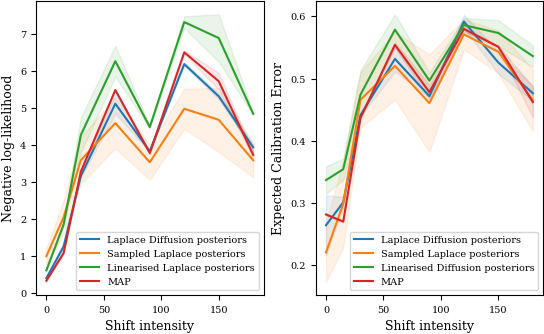

In [19]:
fig, ax = plt.subplots(ncols=2)

uq_metric = 'nll'
lr_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lr])
lr_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lr])
line_1 = ax[0].plot(ids, lr_metric_mean, label="Laplace Diffusion posteriors")
ax[0].fill_between(
    ids, lr_metric_mean - lr_metric_std, lr_metric_mean + lr_metric_std, alpha=0.1, color=line_1[0].get_color()
)
lap_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_posterior])
lap_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_posterior])
line_2 = ax[0].plot(ids, lap_metric_mean, label="Sampled Laplace posteriors")
ax[0].fill_between(
    ids, lap_metric_mean - lap_metric_std, lap_metric_mean + lap_metric_std, alpha=0.1, color=line_2[0].get_color()
)
lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lienarised])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lienarised])
line_3 = ax[0].plot(ids, lin_metric_mean, label="Linearised Laplace posteriors")
ax[0].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_3[0].get_color()
)

map_metric_mean = jnp.array([map[uq_metric+'_mean'] for map in metrics_map])
map_metric_std = jnp.array([map[uq_metric+'_std'] for map in metrics_map])
line_4 = ax[0].plot(ids, map_metric_mean, label="MAP")
ax[0].fill_between(
    ids, map_metric_mean - map_metric_std, map_metric_mean + map_metric_std, alpha=0.1, color=line_4[0].get_color()
)

# plt.title(uq_metric)
ax[0].set_xlabel("Shift intensity")
ax[0].set_ylabel("Negative log-likelihood")
ax[0].legend()

uq_metric = 'ece'
lr_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lr])
lr_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lr])
line_1 = ax[1].plot(ids, lr_metric_mean, label="Laplace Diffusion posteriors")
ax[1].fill_between(
    ids, lr_metric_mean - lr_metric_std, lr_metric_mean + lr_metric_std, alpha=0.1, color=line_1[0].get_color()
)
lap_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_posterior])
lap_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_posterior])
line_2 = ax[1].plot(ids, lap_metric_mean, label="Sampled Laplace posteriors")
ax[1].fill_between(
    ids, lap_metric_mean - lap_metric_std, lap_metric_mean + lap_metric_std, alpha=0.1, color=line_2[0].get_color()
)
lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lienarised])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lienarised])
line_3 = ax[1].plot(ids, lin_metric_mean, label="Linearised Diffusion posteriors")
ax[1].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_3[0].get_color()
)

map_metric_mean = jnp.array([map[uq_metric+'_mean'] for map in metrics_map])
map_metric_std = jnp.array([map[uq_metric+'_std'] for map in metrics_map])
line_4 = ax[1].plot(ids, map_metric_mean, label="MAP")
ax[1].fill_between(
    ids, map_metric_mean - map_metric_std, map_metric_mean + map_metric_std, alpha=0.1, color=line_4[0].get_color()
)

# plt.title(uq_metric)
ax[1].set_xlabel("Shift intensity")
ax[1].set_ylabel("Expected Calibration Error")
ax[1].legend()


plt.savefig(f"./rotated_cifar.pdf")


In [13]:
import pandas as pd
metrics_dict = ['nll', 'ece', 'acc']
method_list = ["Laplace Diffusion", "Sampled Laplace", "Linearised Laplace", "SWAG", "Last-Layer Laplace", "MAP"]
method_dict = {"Laplace Diffusion":metrics_lr, "Sampled Laplace": metrics_posterior,"Linearised Laplace":metrics_lienarised, "SWAG": metrics_swag,
               "Last-Layer Laplace":metrics_llla, "MAP":metrics_map}

df_data = {metric: [float(method_dict[dic][0][metric+'_mean']) for dic in method_dict] for metric in metrics_dict}
# df_data = {k: ["{:.3f}".format(dic[metric+'_mean']) + u"\u00B1" + "{:.3f}".format(dic[metric+'_std'])  for dic in method_dict[k][1:] for metric in metrics_dict] for k in method_dict}

df = pd.DataFrame.from_dict(df_data, orient='index', columns=method_list)
df = df.T

diffusion_dict = {k: df_data[k][0] for k in metrics_dict}
la_dict = {k: df_data[k][1] for k in metrics_dict}
lin_dict = {k: df_data[k][2] for k in metrics_dict}
swag_dict = {k: df_data[k][3] for k in metrics_dict}
llla_dict = {k: df_data[k][4] for k in metrics_dict}
map_dict = {k: df_data[k][5] for k in metrics_dict}

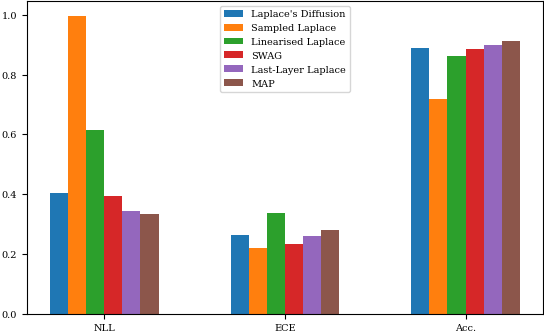

In [14]:
keys = ['NLL', 'ECE', 'Acc.']
Y1 = list(diffusion_dict.values())
Y2 = list(la_dict.values())
Y3 = list(lin_dict.values())
Y4 = list(swag_dict.values())
Y5 = list(llla_dict.values())
Y6 = list(map_dict.values())
X_axis = jnp.arange(len(keys))


plt.bar(X_axis - 0.25, Y1, 0.1, label = "Laplace's Diffusion")
plt.bar(X_axis - 0.15, Y2, 0.1, label = 'Sampled Laplace')
plt.bar(X_axis - 0.05, Y3, 0.1, label='Linearised Laplace')
plt.bar(X_axis + 0.05, Y4, 0.1, label='SWAG')
plt.bar(X_axis + 0.15, Y5, 0.1, label='Last-Layer Laplace')
plt.bar(X_axis + 0.25, Y6, 0.1, label='MAP')

plt.xticks(X_axis, keys)
plt.xlabel = keys
plt.legend()
plt.show()

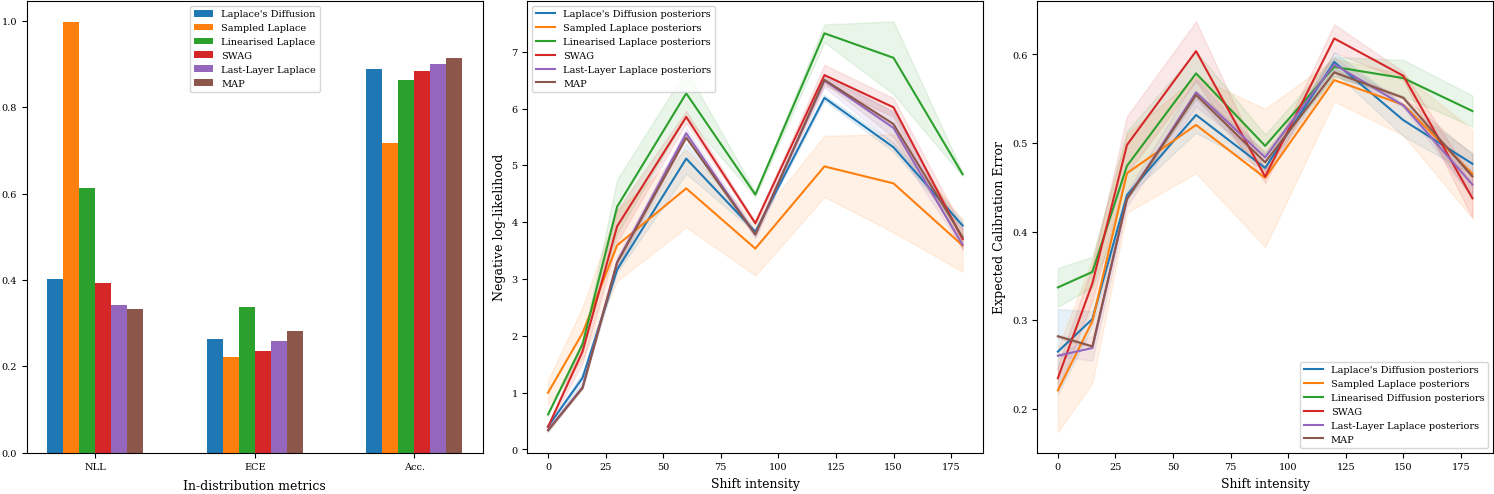

In [15]:
# fig, ax = plt.subplots(ncols=2)

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

keys = ['NLL', 'ECE', 'Acc.']
Y1 = list(diffusion_dict.values())
Y2 = list(la_dict.values())
Y3 = list(lin_dict.values())
Y4 = list(swag_dict.values())
Y5 = list(llla_dict.values())
Y6 = list(map_dict.values())
X_axis = jnp.arange(len(keys))


ax[0].bar(X_axis - 0.25, Y1, 0.1, label = "Laplace's Diffusion")
ax[0].bar(X_axis - 0.15, Y2, 0.1, label = 'Sampled Laplace')
ax[0].bar(X_axis - 0.05, Y3, 0.1, label='Linearised Laplace')
ax[0].bar(X_axis + 0.05, Y4, 0.1, label='SWAG')
ax[0].bar(X_axis + 0.15, Y5, 0.1, label='Last-Layer Laplace')
ax[0].bar(X_axis + 0.25, Y6, 0.1, label='MAP')

ax[0].set_xticks(X_axis, keys)
ax[0].xlabel = keys
ax[0].legend()
ax[0].set_title("In-distribution metrics", y=-0.1)

# plt.savefig('./in_distribution_metrics.pdf')



uq_metric = 'nll'
lr_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lr])
lr_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lr])
line_1 = ax[1].plot(ids, lr_metric_mean, label="Laplace's Diffusion posteriors")
ax[1].fill_between(
    ids, lr_metric_mean - lr_metric_std, lr_metric_mean + lr_metric_std, alpha=0.1, color=line_1[0].get_color()
)
lap_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_posterior])
lap_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_posterior])
line_2 = ax[1].plot(ids, lap_metric_mean, label="Sampled Laplace posteriors")
ax[1].fill_between(
    ids, lap_metric_mean - lap_metric_std, lap_metric_mean + lap_metric_std, alpha=0.1, color=line_2[0].get_color()
)
lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lienarised])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lienarised])
line_3 = ax[1].plot(ids, lin_metric_mean, label="Linearised Laplace posteriors")
ax[1].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_3[0].get_color()
)


lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_swag])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_swag])
line_4 = ax[1].plot(ids, lin_metric_mean, label="SWAG")
ax[1].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_4[0].get_color()
)

lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_llla])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_llla])
line_5 = ax[1].plot(ids, lin_metric_mean, label="Last-Layer Laplace posteriors")
ax[1].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_5[0].get_color()
)

# lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_diag])
# lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_diag])
# line_6 = ax[0].plot(ids, lin_metric_mean, label="Diagonal Laplace posteriors")
# ax[0].fill_between(
#     ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_6[0].get_color()
# )


map_metric_mean = jnp.array([map[uq_metric+'_mean'] for map in metrics_map])
map_metric_std = jnp.array([map[uq_metric+'_std'] for map in metrics_map])
line_7 = ax[1].plot(ids, map_metric_mean, label="MAP")
ax[1].fill_between(
    ids, map_metric_mean - map_metric_std, map_metric_mean + map_metric_std, alpha=0.1, color=line_7[0].get_color()
)
# plt.title(uq_metric)
ax[1].set_xlabel("Shift intensity")
ax[1].set_ylabel("Negative log-likelihood")
ax[1].legend()

uq_metric = 'ece'
lr_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lr])
lr_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lr])
line_1 = ax[2].plot(ids, lr_metric_mean, label="Laplace's Diffusion posteriors")
ax[2].fill_between(
    ids, lr_metric_mean - lr_metric_std, lr_metric_mean + lr_metric_std, alpha=0.1, color=line_1[0].get_color()
)
lap_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_posterior])
lap_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_posterior])
line_2 = ax[2].plot(ids, lap_metric_mean, label="Sampled Laplace posteriors")
ax[2].fill_between(
    ids, lap_metric_mean - lap_metric_std, lap_metric_mean + lap_metric_std, alpha=0.1, color=line_2[0].get_color()
)
lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lienarised])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lienarised])
line_3 = ax[2].plot(ids, lin_metric_mean, label="Linearised Diffusion posteriors")
ax[2].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_3[0].get_color()
)

lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_swag])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_swag])
line_4 = ax[2].plot(ids, lin_metric_mean, label="SWAG")
ax[2].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_4[0].get_color()
)

lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_llla])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_llla])
line_5 = ax[2].plot(ids, lin_metric_mean, label="Last-Layer Laplace posteriors")
ax[2].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_5[0].get_color()
)

# lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_diag])
# lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_diag])
# line_6 = ax[1].plot(ids, lin_metric_mean, label="Diagonal Laplace posteriors")
# ax[1].fill_between(
#     ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_6[0].get_color()
# )


map_metric_mean = jnp.array([map[uq_metric+'_mean'] for map in metrics_map])
map_metric_std = jnp.array([map[uq_metric+'_std'] for map in metrics_map])
line_7 = ax[2].plot(ids, map_metric_mean, label="MAP")
ax[2].fill_between(
    ids, map_metric_mean - map_metric_std, map_metric_mean + map_metric_std, alpha=0.1, color=line_7[0].get_color()
)

# plt.title(uq_metric)
ax[2].set_xlabel("Shift intensity")
ax[2].set_ylabel("Expected Calibration Error")
ax[2].legend()


plt.savefig(f"./apdx_rotated_cifar.pdf")


| Laplace Diffusion |  0.958±0.005 |  170.385±12.506 |  0.911±0.004 |  0.144±0.008 |  0.237±0.033 |  0.852±0.039 | 
| Sampled Laplace |  0.845±0.005 |  438.840±123.643 |  0.742±0.053 |  0.385±0.084 |  0.205±0.045 |  0.799±0.066 | 
| Linearised Laplace |  0.954±0.007 |  285.098±31.782 |  0.871±0.012 |  0.209±0.019 |  0.315±0.036 |  0.799±0.032 | 
| MAP |  0.962±0.004 |  152.471±23.029 |  0.918±0.009 |  0.134±0.015 |  0.272±0.014 |  0.910±0.032 | 


### OOD

In [6]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

# ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
ids = ["CIFAR-10", "CIFAR-100", "SVHN"]

n_datapoint=500
ood_batch_size = 50
metrics_swag = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, batch_stats, swag_posterior) in enumerate(zip(param_list, batch_stats_list, swag_posterior_list)):    
        model_fn = lambda p, x: model.apply({'params': p, 'batch_stats': batch_stats},
                                        x,
                                        train=False,
                                        mutable=False)

        # _, test_loader = get_rotated_cifar_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        _, test_loader = get_cifar10_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, swag_posterior, params, model_fn, eval_args)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="CIFAR-10-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_swag.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_swag[-1].items()]))
    


Files already downloaded and verified


/dtu/p1/hroy/geometric-laplace/src/data/torch_datasets.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = F.one_hot(torch.tensor(self.dataset.targets), len(cls)).numpy()


CIFAR-10-OOD - dataset: CIFAR-10
Files already downloaded and verified
CIFAR-10-OOD - dataset: CIFAR-10
conf_mean: 0.9469, nll_mean: 0.4172, acc_mean: 0.8875, conf_std: 0.0019, nll_std: 0.0341, acc_std: 0.0045
Files already downloaded and verified
CIFAR-10-OOD - dataset: CIFAR-100
Files already downloaded and verified
CIFAR-10-OOD - dataset: CIFAR-100
conf_mean: 0.7731, nll_mean: 0.7156, acc_mean: 0.1056, conf_std: 0.0008, nll_std: 0.0346, acc_std: 0.0286, auroc_mean: 0.8511, fpr95_mean: 0.7317, auroc_std: 0.0024, fpr95_std: 0.0031
Using downloaded and verified file: data/test_32x32.mat
CIFAR-10-OOD - dataset: SVHN
Using downloaded and verified file: data/test_32x32.mat
CIFAR-10-OOD - dataset: SVHN
conf_mean: 0.7252, nll_mean: 6.8414, acc_mean: 0.0999, conf_std: 0.0015, nll_std: 0.8753, acc_std: 0.0035, auroc_mean: 0.8816, fpr95_mean: 0.6484, auroc_std: 0.0035, fpr95_std: 0.0044


In [31]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

# ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
ids = ["CIFAR-10", "CIFAR-100", "SVHN"]

n_datapoint=500
ood_batch_size = 50
metrics_llla = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, batch_stats, ll_posterior) in enumerate(zip(param_list, batch_stats_list, last_layer_list)):    
        model_fn = lambda p, x: model.apply({'params': p, 'batch_stats': batch_stats},
                                        x,
                                        train=False,
                                        mutable=False)

        # _, test_loader = get_rotated_cifar_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        _, test_loader = get_cifar10_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, ll_posterior, params, model_fn, eval_args)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="CIFAR-10-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_llla.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_llla[-1].items()]))
    


Files already downloaded and verified


/dtu/p1/hroy/geometric-laplace/src/data/torch_datasets.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = F.one_hot(torch.tensor(self.dataset.targets), len(cls)).numpy()


CIFAR-10-OOD - dataset: CIFAR-10
Files already downloaded and verified
CIFAR-10-OOD - dataset: CIFAR-10
conf_mean: 0.9527, nll_mean: 0.3431, acc_mean: 0.8990, conf_std: 0.0041, nll_std: 0.0325, acc_std: 0.0010
Files already downloaded and verified
CIFAR-10-OOD - dataset: CIFAR-100
Files already downloaded and verified
CIFAR-10-OOD - dataset: CIFAR-100
conf_mean: 0.7890, nll_mean: 0.7998, acc_mean: 0.0980, conf_std: 0.0064, nll_std: 0.0123, acc_std: 0.0060, auroc_mean: 0.8644, fpr95_mean: 0.6840, auroc_std: 0.0013, fpr95_std: 0.0180
Using downloaded and verified file: data/test_32x32.mat
CIFAR-10-OOD - dataset: SVHN
Using downloaded and verified file: data/test_32x32.mat
CIFAR-10-OOD - dataset: SVHN
conf_mean: 0.7862, nll_mean: 7.1332, acc_mean: 0.0850, conf_std: 0.0289, nll_std: 0.0711, acc_std: 0.0130, auroc_mean: 0.8679, fpr95_mean: 0.6680, auroc_std: 0.0147, fpr95_std: 0.0520


In [32]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["CIFAR-10", "CIFAR-100", "SVHN"]
n_datapoint=500
ood_batch_size = 50
metrics_lr = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, batch_stats, lr_posterior) in enumerate(zip(param_list, batch_stats_list, lr_posterior_list)):   
        model_fn = lambda p, x: model.apply({'params': p, 'batch_stats': batch_stats},
                                x,
                                train=False,
                                mutable=False)    
        _, test_loader = get_cifar10_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, lr_posterior, params, model_fn, eval_args)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="CIFAR-10-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_lr.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_lr[-1].items()]))
    


Files already downloaded and verified


/dtu/p1/hroy/geometric-laplace/src/data/torch_datasets.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = F.one_hot(torch.tensor(self.dataset.targets), len(cls)).numpy()


CIFAR-10-OOD - dataset: CIFAR-10
Files already downloaded and verified
CIFAR-10-OOD - dataset: CIFAR-10
conf_mean: 0.9477, nll_mean: 0.4028, acc_mean: 0.8890, conf_std: 0.0036, nll_std: 0.0068, acc_std: 0.0050
Files already downloaded and verified
CIFAR-10-OOD - dataset: CIFAR-100
Files already downloaded and verified
CIFAR-10-OOD - dataset: CIFAR-100
conf_mean: 0.7897, nll_mean: 0.7417, acc_mean: 0.1300, conf_std: 0.0016, nll_std: 0.0068, acc_std: 0.0200, auroc_mean: 0.8511, fpr95_mean: 0.7350, auroc_std: 0.0023, fpr95_std: 0.0090
Using downloaded and verified file: data/test_32x32.mat
CIFAR-10-OOD - dataset: SVHN
Using downloaded and verified file: data/test_32x32.mat
CIFAR-10-OOD - dataset: SVHN
conf_mean: 0.7640, nll_mean: 7.0313, acc_mean: 0.0910, conf_std: 0.0077, nll_std: 0.1755, acc_std: 0.0050, auroc_mean: 0.8624, fpr95_mean: 0.6920, auroc_std: 0.0096, fpr95_std: 0.0020


In [33]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["CIFAR-10", "CIFAR-100", "SVHN"]
n_datapoint=500
ood_batch_size = 50
metrics_posterior = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, batch_stats, posterior) in enumerate(zip(param_list, batch_stats_list, posterior_list)):    
        model_fn = lambda p, x: model.apply({'params': p, 'batch_stats': batch_stats},
                                        x,
                                        train=False,
                                        mutable=False)    
        _, test_loader = get_cifar10_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, posterior, params, model_fn, eval_args)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="CIFAR-10-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_posterior.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_posterior[-1].items()]))
    


Files already downloaded and verified


/dtu/p1/hroy/geometric-laplace/src/data/torch_datasets.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = F.one_hot(torch.tensor(self.dataset.targets), len(cls)).numpy()


CIFAR-10-OOD - dataset: CIFAR-10
Files already downloaded and verified
CIFAR-10-OOD - dataset: CIFAR-10
conf_mean: 0.8428, nll_mean: 0.9966, acc_mean: 0.7170, conf_std: 0.0039, nll_std: 0.2220, acc_std: 0.0490
Files already downloaded and verified
CIFAR-10-OOD - dataset: CIFAR-100
Files already downloaded and verified
CIFAR-10-OOD - dataset: CIFAR-100
conf_mean: 0.7270, nll_mean: 0.6504, acc_mean: 0.1210, conf_std: 0.0258, nll_std: 0.0851, acc_std: 0.0430, auroc_mean: 0.6874, fpr95_mean: 0.8890, auroc_std: 0.0334, fpr95_std: 0.0250
Using downloaded and verified file: data/test_32x32.mat
CIFAR-10-OOD - dataset: SVHN
Using downloaded and verified file: data/test_32x32.mat
CIFAR-10-OOD - dataset: SVHN
conf_mean: 0.7920, nll_mean: 7.1695, acc_mean: 0.1050, conf_std: 0.0223, nll_std: 0.4681, acc_std: 0.0030, auroc_mean: 0.5995, fpr95_mean: 0.9410, auroc_std: 0.0381, fpr95_std: 0.0130


In [34]:
eval_args = {}
eval_args["linearised_laplace"] = True
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["CIFAR-10", "CIFAR-100", "SVHN"]
n_datapoint=500
ood_batch_size = 50
metrics_linearised = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, batch_stats, posterior) in enumerate(zip(param_list, batch_stats_list, posterior_list)):    
        model_fn = lambda p, x: model.apply({'params': p, 'batch_stats': batch_stats},
                                        x,
                                        train=False,
                                        mutable=False)    
        _, test_loader = get_cifar10_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, posterior, params, model_fn, eval_args)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="CIFAR-10-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_linearised.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_linearised[-1].items()]))
    


Files already downloaded and verified


/dtu/p1/hroy/geometric-laplace/src/data/torch_datasets.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = F.one_hot(torch.tensor(self.dataset.targets), len(cls)).numpy()


CIFAR-10-OOD - dataset: CIFAR-10
Files already downloaded and verified
CIFAR-10-OOD - dataset: CIFAR-10
conf_mean: 0.9510, nll_mean: 0.6136, acc_mean: 0.8630, conf_std: 0.0069, nll_std: 0.0202, acc_std: 0.0010
Files already downloaded and verified
CIFAR-10-OOD - dataset: CIFAR-100
Files already downloaded and verified
CIFAR-10-OOD - dataset: CIFAR-100
conf_mean: 0.8182, nll_mean: 0.9811, acc_mean: 0.1040, conf_std: 0.0053, nll_std: 0.0016, acc_std: 0.0020, auroc_mean: 0.8372, fpr95_mean: 0.7760, auroc_std: 0.0059, fpr95_std: 0.0180
Using downloaded and verified file: data/test_32x32.mat
CIFAR-10-OOD - dataset: SVHN
Using downloaded and verified file: data/test_32x32.mat
CIFAR-10-OOD - dataset: SVHN
conf_mean: 0.8092, nll_mean: 8.3916, acc_mean: 0.0950, conf_std: 0.0332, nll_std: 0.8858, acc_std: 0.0030, auroc_mean: 0.8536, fpr95_mean: 0.7570, auroc_std: 0.0242, fpr95_std: 0.0370


In [35]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["CIFAR-10", "CIFAR-100", "SVHN"]
n_datapoint=500
ood_batch_size = 50
metrics_map = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, batch_stats) in enumerate(zip(param_list, batch_stats_list)):    
        model_fn = lambda p, x: model.apply({'params': p, 'batch_stats': batch_stats},
                                        x,
                                        train=False,
                                        mutable=False)    
        # params = params_dict['params']
        _, test_loader = get_cifar10_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate_map(test_loader, params, model_fn, eval_args)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="CIFAR-10-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_map.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_map[-1].items()]))
    


Files already downloaded and verified


/dtu/p1/hroy/geometric-laplace/src/data/torch_datasets.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = F.one_hot(torch.tensor(self.dataset.targets), len(cls)).numpy()


CIFAR-10-OOD - dataset: CIFAR-10
Files already downloaded and verified
CIFAR-10-OOD - dataset: CIFAR-10
conf_mean: 0.9597, nll_mean: 0.3327, acc_mean: 0.9130, conf_std: 0.0031, nll_std: 0.0295, acc_std: 0.0070
Files already downloaded and verified
CIFAR-10-OOD - dataset: CIFAR-100
Files already downloaded and verified
CIFAR-10-OOD - dataset: CIFAR-100
conf_mean: 0.7967, nll_mean: 0.8014, acc_mean: 0.1220, conf_std: 0.0038, nll_std: 0.0302, acc_std: 0.0060, auroc_mean: 0.8727, fpr95_mean: 0.6510, auroc_std: 0.0005, fpr95_std: 0.0130
Using downloaded and verified file: data/test_32x32.mat
CIFAR-10-OOD - dataset: SVHN
Using downloaded and verified file: data/test_32x32.mat
CIFAR-10-OOD - dataset: SVHN
conf_mean: 0.7921, nll_mean: 7.3997, acc_mean: 0.0910, conf_std: 0.0344, nll_std: 0.1121, acc_std: 0.0110, auroc_mean: 0.8785, fpr95_mean: 0.6550, auroc_std: 0.0172, fpr95_std: 0.0670


In [36]:
import pandas as pd
metrics_dict = ['conf', 'auroc']
method_list = ["Laplace Diffusion", "Sampled Laplace", "Linearised Laplace", "SWAG", "Last-Layer Laplace", "MAP"]
method_dict = {"Laplace Diffusion":metrics_lr, "Sampled Laplace": metrics_posterior,"Linearised Laplace":metrics_linearised, "SWAG": metrics_swag,
               "Last-Layer Laplace":metrics_llla, "MAP":metrics_map}
mux = pd.MultiIndex.from_product([ids[1:], metrics_dict])
# df_data = {k: [dic[metric+'_mean'] for metric in metrics_dict for dic in method_dict[k][1:]] for k in method_dict}
df_data = {k: ["{:.3f}".format(dic[metric+'_mean']) + u"\u00B1" + "{:.3f}".format(dic[metric+'_std'])  for dic in method_dict[k][1:] for metric in metrics_dict] for k in method_dict}

df = pd.DataFrame.from_dict(df_data, orient='index',
                       columns=mux)


In [37]:
df

CIFAR-100                      SVHN             
                           conf        auroc         conf        auroc
Laplace Diffusion   0.790±0.002  0.851±0.002  0.764±0.008  0.862±0.010
Sampled Laplace     0.727±0.026  0.687±0.033  0.792±0.022  0.599±0.038
Linearised Laplace  0.818±0.005  0.837±0.006  0.809±0.033  0.854±0.024
SWAG                0.776±0.009  0.845±0.008  0.729±0.009  0.876±0.003
Last-Layer Laplace  0.789±0.006  0.864±0.001  0.786±0.029  0.868±0.015
MAP                 0.797±0.004  0.873±0.001  0.792±0.034  0.878±0.017

In [38]:
print(df.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))  

\begin{tabular}{lllll}
\toprule
 & \multicolumn{2}{r}{CIFAR-100} & \multicolumn{2}{r}{SVHN} \\
 & conf & auroc & conf & auroc \\
\midrule
Laplace Diffusion & 0.790±0.002 & 0.851±0.002 & 0.764±0.008 & 0.862±0.010 \\
Sampled Laplace & 0.727±0.026 & 0.687±0.033 & 0.792±0.022 & 0.599±0.038 \\
Linearised Laplace & 0.818±0.005 & 0.837±0.006 & 0.809±0.033 & 0.854±0.024 \\
SWAG & 0.776±0.009 & 0.845±0.008 & 0.729±0.009 & 0.876±0.003 \\
Last-Layer Laplace & 0.789±0.006 & 0.864±0.001 & 0.786±0.029 & 0.868±0.015 \\
MAP & 0.797±0.004 & 0.873±0.001 & 0.792±0.034 & 0.878±0.017 \\
\bottomrule
\end{tabular}



| Laplace Diffusion | 0.791±0.001 | 0.856±0.002 | 0.793±0.019 | 0.852±0.013 |
| Laplace Approximation | 0.706±0.037 | 0.730±0.039 | 0.757±0.053 | 0.667±0.068 |
| Linearised Laplace | 0.818±0.004 | 0.839±0.005 | 0.805±0.028 | 0.853±0.020 |
| MAP | 0.803±0.010 | 0.877±0.005 | 0.790±0.028 | 0.884±0.013 |
